**1.0 INSTALL AND INITIALIZE NECESSARY LIBRARIES AND PACKAGES**

**1.1 Installation**

In [9]:
%pip install geemap geedim folium earthengine-api google-auth matplotlib numpy rasterio geopandas osmnx
import geemap
import folium
import ee
from google.oauth2 import service_account
import os
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.plot import show

Note: you may need to restart the kernel to use updated packages.


**1.2 Initialize Earth Engine Resources**

In [10]:
# Set the path to the service account key file (replace with your actual path)

service_account_key_file = 'sigma-hallway-357006-ad5b9b727b59.json'

# Google Cloud project ID (replace with your actual project ID)
project_id = 'sigma-hallway-357006'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    service_account_key_file,
    scopes=['https://www.googleapis.com/auth/earthengine']
)

# Initialize the Earth Engine library using the loaded credentials
ee.Initialize(credentials, project=project_id)


**2.0 DOWNLOAD LANDSCAPE ELEMENTS**

The boundary of Nigeria is first loaded and used as the basis for clipping all Earth Engine Resources.

**2.1 Land Cover - ESA [2021]**

In [11]:
# Define the region of interest (Nigeria's boundary) as a FeatureCollection
nigeria_boundary_fc = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na', 'Nigeria'))

# Convert the boundary to a geometry for clipping
nigeria_boundary_geom = nigeria_boundary_fc.geometry()

# Load the ESA WorldCover v200 dataset
esa_worldcover = ee.ImageCollection("ESA/WorldCover/v200").first()

# Clip the image to the region of interest
nigeria_landcover = esa_worldcover.clip(nigeria_boundary_geom)

# Set the output resolution to 1000 meters
nigeria_landcover = nigeria_landcover.reproject(crs='EPSG:3857', scale=1000)

# Define the output folder and file names
output_folder = 'Dataset'
output_path = os.path.join(output_folder, 'Nigeria_Landcover_2021.tif')
output_path2 = os.path.join(output_folder, 'nigeria_boundary.geojson')

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Download the landcover data as a GeoTIFF
geemap.download_ee_image(nigeria_landcover, filename=output_path, scale=1000, region=nigeria_boundary_geom)

# Download the Nigeria boundary as a GeoJSON file
geemap.ee_export_vector(nigeria_boundary_fc, filename=output_path2)

# Print a message when the download is complete
print("Download complete!")

Nigeria_Landcover_2021.tif: |          | 0.00/1.45M (raw) [  0.0%] in 00:00 (eta:     ?)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\EnechePSU\OneDrive - University of Twente\Documents\GitHub\landscape-character-nigeria\GEE_Dataset\Dataset\nigeria_boundary.geojson
Download complete!


**2.2 Elevation and Hillshade Acquisition**

*This project makes use of the Shuttle Radar Topographic Mission (SRTM) digital elevation data (Version 4), which has been processed to fill data voids by the Consultative Group for International Agricultural Research (CGIAR). Elevation is then classified and downloaded. Also, from the SRTM data, hillshade is also computed and downloaded.*


In [12]:
# Load the SRTM dataset
srtm = ee.Image('CGIAR/SRTM90_V4').clip(nigeria_boundary_geom)

# Threshold used for classification
elevation_thresholds = [100, 500, 1000, 1500, 2500]

classified_elevation = srtm \
    .where(srtm.lte(elevation_thresholds[0]), 1) \
    .where(srtm.gt(elevation_thresholds[0]).And(srtm.lte(elevation_thresholds[1])), 2) \
    .where(srtm.gt(elevation_thresholds[1]).And(srtm.lte(elevation_thresholds[2])), 3) \
    .where(srtm.gt(elevation_thresholds[2]).And(srtm.lte(elevation_thresholds[3])), 4) \
    .where(srtm.gt(elevation_thresholds[3]).And(srtm.lte(elevation_thresholds[4])), 5) \
    .where(srtm.gt(elevation_thresholds[4]), 5)

# Set the output resolution to 1000 meters
classified_elevation = classified_elevation.reproject(crs='EPSG:3857', scale=1000)

# Save the file...
output_path = os.path.join(output_folder, 'Classified_Altitude_Nigeria.tif')

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Download the classified hillshade data as a single GeoTIFF file
geemap.download_ee_image(classified_elevation, filename=output_path, scale=1000, region=nigeria_boundary_geom)

# Print a message when the download is complete
print("Download complete!")

Classified_Altitude_Nigeria.tif: |          | 0.00/2.91M (raw) [  0.0%] in 00:00 (eta:     ?)

Download complete!


In [13]:
# Compute the hillshade (shaded relief)
exaggeration = 20
hillshade = ee.Terrain.hillshade(srtm.multiply(exaggeration))

# Define the thresholds for classification
hillshade_thresholds = [50, 100, 150, 200, 250]

# Classify the hillshade data using the defined thresholds
classified_hillshade = hillshade \
    .where(hillshade.lte(hillshade_thresholds[0]), 1) \
    .where(hillshade.gt(hillshade_thresholds[0]).And(hillshade.lte(hillshade_thresholds[1])), 2) \
    .where(hillshade.gt(hillshade_thresholds[1]).And(hillshade.lte(hillshade_thresholds[2])), 3) \
    .where(hillshade.gt(hillshade_thresholds[2]).And(hillshade.lte(hillshade_thresholds[3])), 4) \
    .where(hillshade.gt(hillshade_thresholds[3]).And(hillshade.lte(hillshade_thresholds[4])), 5) \
    .where(hillshade.gt(hillshade_thresholds[4]), 5)  # Any value above the highest threshold

# Set the output resolution to 1000 meters
classified_hillshade = classified_hillshade.reproject(crs='EPSG:3857', scale=1000)

# Save the file...
output_path = os.path.join(output_folder, 'Classified_Hillshade_Nigeria.tif')

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Download the classified hillshade data as a single GeoTIFF file
geemap.download_ee_image(classified_hillshade, filename=output_path, scale=1000, region=nigeria_boundary_geom)

# Print a message when the download is complete
print("Download complete!")



Classified_Hillshade_Nigeria.tif: |          | 0.00/1.45M (raw) [  0.0%] in 00:00 (eta:     ?)

Download complete!


**2.3 Land Surface Temperature - Mean**

*MODIS land surface temperature (LST) is used and the mean of 4 years is computed*


In [14]:
# Define the start and end dates (optional)
start_date = ee.Date('2020-01-01')
end_date = ee.Date('2023-12-30')

# Load MODIS Land Surface Temperature (LST) data and filter by date (optional)
modis_lst = ee.ImageCollection('MODIS/006/MOD11A1').select('LST_Day_1km').filterDate(start_date, end_date)

# Calculate the mean LST over the period of interest
mean_lst = modis_lst.mean().clip(nigeria_boundary_geom)

# Convert from Kelvin to Celsius (MODIS LST is scaled by 0.02)
mean_lst_celsius = mean_lst.multiply(0.02).subtract(273.15)

# Fill missing values in LST using focal median
mean_lst_filled = mean_lst_celsius.focal_median(radius=1, units='pixels')

# Set the output resolution (1000 meters)
Mean_LST = mean_lst_filled.reproject(crs='EPSG:3857', scale=1000)

# Save the file...
output_path = os.path.join(output_folder, 'Mean_LST_Nigeria.tif')

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Download the LST data as a single GeoTIFF file
geemap.download_ee_image(Mean_LST, filename=output_path, scale=1000, region=nigeria_boundary_geom)

# Print a message when the download is complete
print("Download complete!")

Mean_LST_Nigeria.tif: |          | 0.00/11.6M (raw) [  0.0%] in 00:00 (eta:     ?)

Download complete!


**3.0 VISUALIZATION**

**3.1 GEEMAP**

In [15]:
# Create an interactive map
Map = geemap.Map(center=[9.0820, 8.6753], zoom=6)

# Add the SRTM elevation data to the map with a terrain-like color palette
Map.addLayer(srtm, {'min': 0, 'max': 3000, 'palette': ['#0000ff', '#00ffff', '#00ff00', '#ffff00', '#ff0000', '#7f0000']}, 'SRTM Elevation')
Map.addLayer(classified_elevation, {'min': 1, 'max': 5, 'palette': ['#dbe8f5', 'green', 'yellow', 'orange', 'red', 'purple']}, 'Classified Elevation')
Map.addLayer(nigeria_landcover, {'min': 10, 'max': 95, 'palette': ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4', '#0064c8', '#0096a0', '#00cf75']}, 'Land Cover')
Map.addLayer(classified_hillshade, {'min': 1, 'max': 5, 'palette': ['blue', 'green', 'yellow', 'orange', 'red', 'purple']}, 'Classified Hillshade')
Map.addLayer(Mean_LST, {'min': 20, 'max': 43, 'palette': ['blue', 'yellow', 'orange', 'red']}, 'Mean LST')

# Display the map
Map

Map(center=[9.082, 8.6753], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

**3.2 Plot Locally**

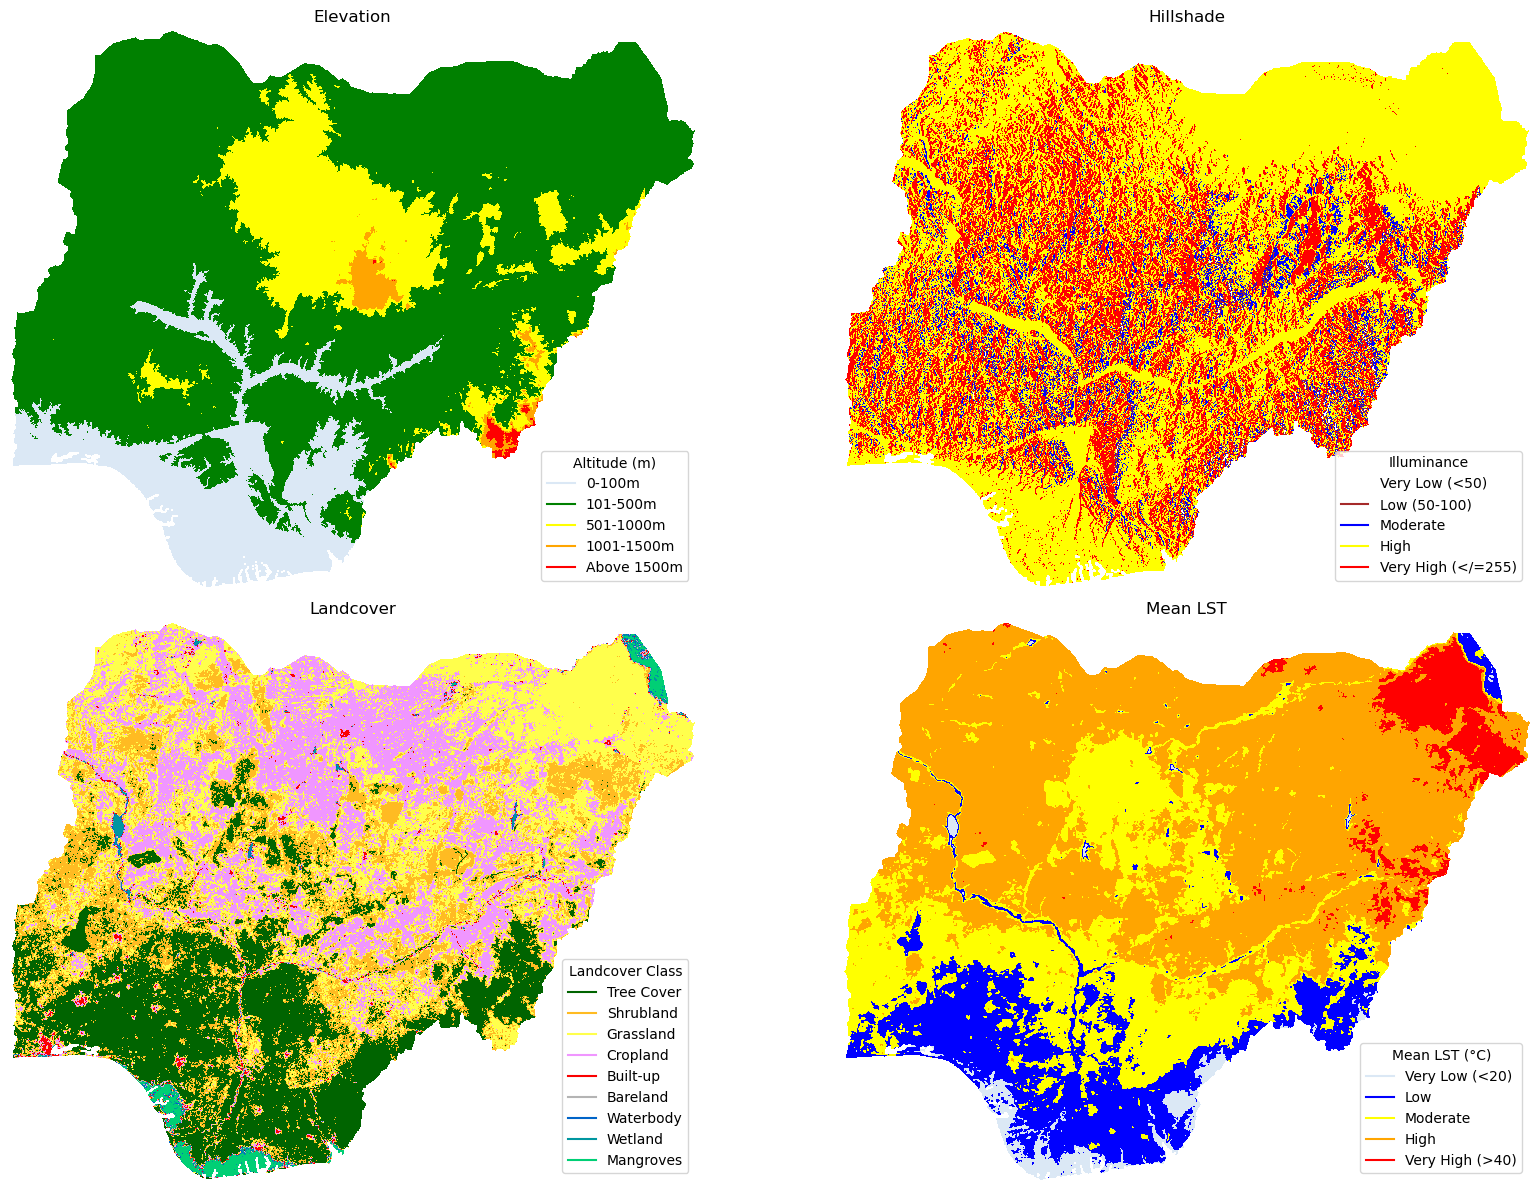

In [18]:
# Load classified images
landcover_path = 'Dataset/Nigeria_Landcover_2021.tif'
elevation_path = 'Dataset/Classified_Altitude_Nigeria.tif'
hillshade_path = 'Dataset/Classified_Hillshade_Nigeria.tif'
lst_path = 'Dataset/Mean_LST_Nigeria.tif'

# Load images
with rasterio.open(landcover_path) as src:
    landcover = src.read(1)
    landcover_masked = np.ma.masked_equal(landcover, 0)  # Mask NoData (value 0)

with rasterio.open(elevation_path) as src:
    elevation = src.read(1)
    # Ensure the masking of the elevation data
    elevation_masked = np.ma.masked_equal(elevation, 0)  # Mask NoData (value 0)
    elevation_masked = np.ma.masked_equal(elevation_masked, -32768)  # Mask NoData (-32768)

with rasterio.open(hillshade_path) as src:
    hillshade = src.read(1)
    hillshade_masked = np.ma.masked_equal(hillshade, 0)  # Mask NoData (value 0)

with rasterio.open(lst_path) as src:
    lst = src.read(1)
    lst_masked = np.ma.masked_equal(lst, 0)  # Mask NoData (value 0)
    
# Define color maps and legends for each image
landcover_cmap = ListedColormap(['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4', '#0064c8', '#0096a0', '#00cf75'])
elevation_cmap = ListedColormap(['#dbe8f5', 'green', 'yellow', 'orange', 'red'])  # Adjust color map to match the elevation classes
hillshade_cmap = ListedColormap(['white', 'brown', 'blue', 'yellow', 'red'])
lst_cmap = ListedColormap(['#dbe8f5', 'blue', 'yellow', 'orange', 'red'])

landcover_legend_labels = ['Tree Cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bareland', 'Waterbody', 'Wetland', 'Mangroves']
elevation_legend_labels = ['0-100m', '101-500m', '501-1000m', '1001-1500m', 'Above 1500m']
hillshade_legend_labels = ['Very Low (<50)', 'Low (50-100)', 'Moderate', 'High', 'Very High (</=255)']
lst_legend_labels = ['Very Low (<20)', 'Low', 'Moderate', 'High', 'Very High (>40)']

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot elevation
elevation_img = axs[0, 0].imshow(elevation_masked, cmap=elevation_cmap)
axs[0, 0].set_title('Elevation')
axs[0, 0].axis('off')

# Create a list of patches for the elevation legend
elevation_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(elevation_cmap.colors, elevation_legend_labels)]

# Create the elevation legend
elevation_legend = axs[0, 0].legend(title='Altitude (m)', handles=elevation_patches, loc='lower right')

# Plot hillshade
hillshade_img = axs[0, 1].imshow(hillshade_masked, cmap=hillshade_cmap)
axs[0, 1].set_title('Hillshade')
axs[0, 1].axis('off')

# Create a list of patches for the hillshade legend
hillshade_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(hillshade_cmap.colors, hillshade_legend_labels)]

# Create the hillshade legend
hillshade_legend = axs[0, 1].legend(title='Illuminance', handles=hillshade_patches, loc='lower right')

# Plot landcover
landcover_img = axs[1, 0].imshow(landcover_masked, cmap=landcover_cmap)
axs[1, 0].set_title('Landcover')
axs[1, 0].axis('off')


# Create a list of patches for the landcover legend
landcover_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(landcover_cmap.colors, landcover_legend_labels)]

# Create the landcover legend
landcover_legend = axs[1, 0].legend(title='Landcover Class', handles=landcover_patches, loc='lower right')

# Plot lst
lst_img = axs[1, 1].imshow(lst_masked, cmap=lst_cmap)
axs[1, 1].set_title('Mean LST')
axs[1, 1].axis('off')

# Create a list of patches for the LST legend
lst_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(lst_cmap.colors, lst_legend_labels)]

# Create the hillshade legend
lst_legend = axs[1, 1].legend(title='Mean LST (°C)', handles=lst_patches, loc='lower right')

# Turn off axis labels and ticks for the empty subplot
#axs[1, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig('Dataset/input_dataset_all.png')
plt.savefig('Dataset/input_dataset_all.svg')
plt.show()



**Next step is to move to cluster_analysis.ipynb where landscape character assessment will be commenced**